In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot
from jaxopt import LBFGS
import skfem as fem
from skfem.helpers import dot, grad
import meshio
import numpy as np
from skfem import MeshQuad

# Make sure JAX uses 64-bit floats for better numerical stability in optimization
jax.config.update("jax_enable_x64", True)

# How JAX Works

The fundamental data structure is the `jnp.array()`, which is very like a numpy array. Similar to PyTorch tensor. 

Different than PyTorch, since in PyTorch, you operate on a tensor and then take the gradient of it, after all the operations. In JAX, a `jnp.array()` is *immutable*. You define functions that transform an array into another copy of an array. 

Decorator `@jax.jit` means "just-in-time", meaning it compiles once, and then, based on function tree, can trace the tree back and do backprop like in PyTorch. Except compiling all at once makes it reuseable and faster, where in PyTorch it is built dynamically. 

Use the `@jax.jit` decorator when you have a function that runs many times, so it can optimize it. Remember, all these functions are static, so it will just take in an input and spit out an output, so you can just have JAX optimize this. 

Note: sometimes if the structure of the arguments change (like different length of array), or your new arguments change control flow (longer loop iterations or if statements), then JAX will recompile, even with the `@jax.jit` decorator. Just be mindful of this if it is running slower than expected. 

In [125]:
# 📈 Define the Synthetic Data (y = 2*x + 1, plus some noise)
X = jnp.array([1.0, 2.0, 3.0, 4.0, 5.0])
Y = jnp.array([3.1, 5.2, 6.9, 9.1, 11.2])

# Define the Linear Model: y_pred = m*x + c
def model(params, x):
    m, c = params
    return m * x + c

# 📉 Mean Squared Error Loss
def loss_function(params, X, Y):
    """Calculates the MSE loss for a linear model."""
    return jnp.mean((model(params,X) - Y)**2)

In [126]:
# Literally takes in an array (+ some static parameters), returns an array. Completely static. Depends only on the definiton of the loss function.

@jax.jit
def update_step(params,X,Y,learning_rate):
    gradient_fn = jax.grad(loss_function)
    grads = gradient_fn(params,X,Y) # But we only care about grad wrt to params

    new_m = params[0] - learning_rate * grads[0]
    new_c = params[1] - learning_rate * grads[1]

    # 3. Return the new, updated parameters
    return jnp.array([new_m, new_c])

In [127]:
# ⚙️ Hyperparameters and Initial State
learning_rate = 0.05
num_epochs = 1000
params = jnp.array([0.0, 0.0])  # Initial guess (m, c)

print(f"Starting parameters (m, c): ({params[0]:.4f}, {params[1]:.4f})")

# 🔁 Optimization Loop
for epoch in range(num_epochs):
    # Call the JIT-compiled update function
    params = update_step(params, X, Y, learning_rate)
    
    # Optional: Print loss every 100 epochs
    if epoch % 100 == 0:
        current_loss = loss_function(params, X, Y)
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

# 💡 Display Results
final_loss = loss_function(params, X, Y)
m_optimized, c_optimized = params

Starting parameters (m, c): (0.0000, 0.0000)
Epoch 0: Loss = 2.011204
Epoch 100: Loss = 0.013121
Epoch 200: Loss = 0.011844
Epoch 300: Loss = 0.011801
Epoch 400: Loss = 0.011800
Epoch 500: Loss = 0.011800
Epoch 600: Loss = 0.011800
Epoch 700: Loss = 0.011800
Epoch 800: Loss = 0.011800
Epoch 900: Loss = 0.011800


How is JAX different from PyTorch? A PyTorch optimization loop simply calls `loss.backwards()` to get gradients, and `optimizer.step()` to use those gradients to modify the gradients in place. It will re-run the backprop process every time. JAX defines a static function that can be compiled such that the entire backprop process is static, and can be called with a parameters array input, then outputs an array.

Minimization functions take in your loss function as a parameter, and do the same style of optimization loop as above.

# Testing Reading a .msh file with meshio

In [128]:
import meshio
import numpy as np

# Load the .msh file generated by Gmsh
mesh = meshio.read("charge_background.msh")

# --- Extract Global Nodal Data (Geometry) ---
# 'points' is an Nx3 NumPy array where N is the total number of nodes.
# Since your mesh is 2D, the third column (Z-coordinate) will be zero.
points = mesh.points
print(f"Total nodes (points): {len(points)}")

# --- Extract Element Connectivity (Topology) ---
# 'cells' is a list of tuples, where each tuple describes an element type
# (e.g., 'triangle', 'tetra', 'quad') and the connectivity array for those elements.
cells = mesh.cells


Total nodes (points): 74


In [129]:
# --- 1. Accessing Connectivity Directly ---

# Use the .cells_dict property to get the connectivity array for 'triangle' elements.
# This assumes your mesh consists of linear triangles (3 nodes per element).
try:
    triangle_connectivity = mesh.cells_dict["triangle"] # Indices of three points
except KeyError:
    # If the key 'triangle' doesn't exist, check for other possible triangle types
    # (e.g., quadratic 'triangle6', though 'triangle' is most common)
    print("Error: Could not find 'triangle' element type in the mesh.")
    print("Available types:", list(mesh.cells_dict.keys()))
    triangle_connectivity = None


# --- 2. Accessing Nodal Coordinates ---
points = mesh.points # array of (x,y,z)

# --- 3. Accessing Physical Tags (for materials/regions) ---
# These tags (IDs 1, 2, 3, 4, 5...) are usually stored under the 'gmsh:physical' key.
# You need to access the data corresponding to the 'triangle' cells.
triangle_tags = mesh.cell_data_dict["gmsh:physical"]["triangle"] 

print(f"Total Nodes: {len(points)}")
print(f"Total Triangle Elements: {len(triangle_connectivity)}")

# m = 0
# for l in range(len(mesh.points)):
#     m = max(len([t for t in triangle_connectivity if 65 in t]),m)

# print(f"Max connected is: {m}")

# Now you have your three main inputs (points, connectivity, tags) ready for JAX.

Total Nodes: 74
Total Triangle Elements: 118


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


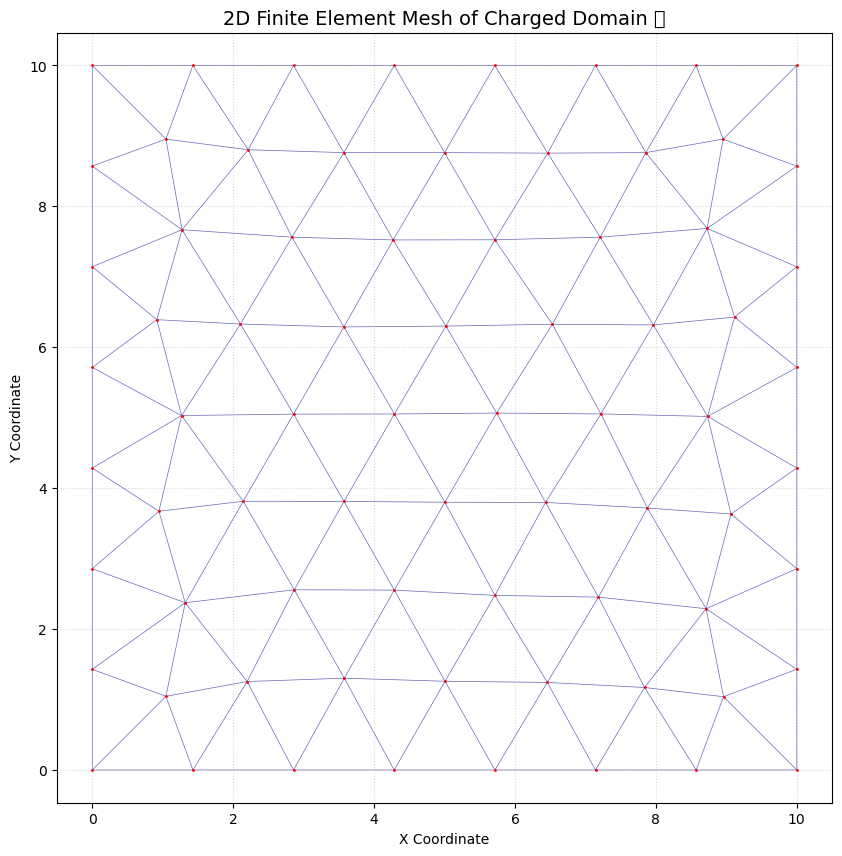

In [ ]:

# Note: You should have already loaded the 'mesh' object using meshio
# and extracted 'points' and 'triangle_connectivity' as described previously.

# --- Data Preparation ---
# 1. Extract X and Y coordinates (we ignore the Z-column for 2D plotting)
x_coords = points[:, 0]
y_coords = points[:, 1]

# 2. Use the connectivity array directly. It lists the node indices for each triangle.
triangles = triangle_connectivity

# --- Plotting the Mesh ---
plt.figure(figsize=(10, 10))

# Use triplot to draw the mesh elements
# color='gray' and linewidth=0.5 provides a clear view of the element boundaries.
plt.triplot(x_coords, y_coords, triangles, 
            color='darkblue', 
            linewidth=0.5, 
            alpha=0.6)

# Highlight the nodes as small dots
plt.plot(x_coords, y_coords, 'o', color='red', markersize=1) 

# --- Formatting ---
plt.title('2D Finite Element Mesh of Charged Domain 🌐', fontsize=14)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal') # Ensures the 10x10 square and the circle look geometrically correct
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

In [131]:
# Write a function, convert into a coefficients of basis over mesh, and then use those to take integral. Then check numerical integral too


In [132]:
import gmsh
import numpy as np

def generate_adaptive_mesh(min_lc_factor=0.01, max_lc=0.5):
    """
    Generates a 2D mesh based on an implicit indicator function boundary,
    applying adaptive refinement near the boundary using GMSH fields.

    Args:
        min_lc_factor (float): Minimum mesh size factor relative to domain size (controls refinement).
        max_lc (float): Maximum allowed mesh size away from the boundary (controls coarseness).
    """
    # 1. Initialize GMSH
    gmsh.initialize()
    gmsh.model.add("indicator_mesh")

    # Define the domain size (e.g., 10x10)
    domain_size = 10.0
    lc_min = domain_size * min_lc_factor

    # --- 2. Geometry Creation (Simulating the u=1 Region Boundary) ---
    # We define a large square domain (u=0 space) with a smaller square hole (u=1 region)
    
    # 2.1 Outer Boundary (Domain: -5 to 5)
    outer_tag = gmsh.model.occ.addRectangle(-domain_size/2, -domain_size/2, 0, domain_size, domain_size)

    # 2.2 Inner Boundary (Hole/Inclusion: -1 to 1) - This is our 'u=0/u=1' boundary
    inner_size = 2.0
    inner_tag = gmsh.model.occ.addRectangle(-inner_size/2, -inner_size/2, 0, inner_size, inner_size)

    # 2.3 Create the Surface (Difference operation to get the ring)
    # The surface will be the region between the outer boundary and the inner boundary.
    surface, _ = gmsh.model.occ.cut([(2, outer_tag)], [(2, inner_tag)])
    surface_tag = surface[0][1]

    gmsh.model.occ.synchronize()

    # --- 3. Define the Adaptive Mesh Size Field ---
    # We want the mesh size to be controlled by the distance to the inner boundary curves.

    # 3.1 Get the curves forming the boundary of the 'u=1' region (the hole)
    # We use the GMSH hierarchy to find the boundary of the inner rectangle.
    # The 'surface' entity is (2, surface_tag). Its boundary is a list of curves.
    boundary_entities = gmsh.model.getBoundary([(2, surface_tag)], combined=False)
    
    # Filter only the inner curves (dim=1) which are part of the hole.
    # We know the outer boundary is curves (1, tag) and inner are curves (1, tag).
    # Since we did a 'cut', the inner boundary curves are now part of the surface's boundary.
    # For simplicity, let's identify the 4 curves of the inner boundary directly.
    # (A robust approach would use getBoundary on the 'surface' and select the inner ones, 
    # but based on the OCC geometry creation order, we can infer them).
    
    # The inner boundary is defined by the 4 curves of the 'inner_tag' rectangle.
    # We can get the curves from the wire surrounding the inner rectangle.
    inner_wire = gmsh.model.getBoundary([(2, inner_tag)], combined=True)
    
    # The inner_wire is a single wire (dim=1). Get its boundary curves (dim=1).
    inner_curves = gmsh.model.getBoundary(inner_wire, combined=False)
    
    # Extract the curve tags (only dim=1 entities)
    curve_tags = [tag for dim, tag in inner_curves if dim == 1]
    
    if not curve_tags:
        print("Error: Could not find inner boundary curves for meshing field.")
        gmsh.finalize()
        return

    # 3.2 Create a Distance Field (Field 1)
    # This field calculates the distance from any point in the domain to the specified curves.
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "CurvesList", curve_tags)

    # 3.3 Create a Threshold Field (Field 2)
    # This field converts the distance (Field 1) into a mesh size (Lc)
    # Lc = Lc_min when Distance <= R_min (e.g., 0.1)
    # Lc = Lc_max when Distance >= R_max (e.g., 3.0)
    # Lc transitions linearly between R_min and R_max.
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "InField", 1) # Use the Distance field as input
    gmsh.model.mesh.field.setNumber(2, "SizeMin", lc_min)
    gmsh.model.mesh.field.setNumber(2, "SizeMax", max_lc)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 0.5) # Distance at which Lc starts to increase
    gmsh.model.mesh.field.setNumber(2, "DistMax", 3.0) # Distance at which Lc reaches Max

    # 3.4 Apply the field
    gmsh.model.mesh.field.setAsBackgroundMesh(2)
    
    # Optionally, set a global minimum element size limit
    gmsh.option.setNumber("Mesh.LcMin", lc_min)
    
    # --- 4. Mesh Generation and Output ---
    print(f"Generating 2D mesh (Lc_min={lc_min}, Lc_max={max_lc})...")
    gmsh.model.mesh.generate(2)
    
    # Save the mesh to a file
    gmsh.write("adaptive_indicator_mesh.msh")

    # Visualize the result (optional)
    if '-nopopup' not in gmsh.sys.argv:
        gmsh.fltk.run()

    # Finalize GMSH
    gmsh.finalize()

if __name__ == "__main__":
    generate_adaptive_mesh(min_lc_factor=0.005, max_lc=1.0)

Error   : Unknown model face with tag 2


Exception: Unknown model face with tag 2

# Taking the Integral: Scikit-FEM

The last argument of each form is a `w` object that tells you where in the domain you are, and when doing numerical integration, what the element / quadrature size, etc... are

In [ ]:
import skfem as fem
from skfem.helpers import dot, grad

# A Bilinear Functional
@fem.BilinearForm
def a(u,v,_):
    return dot(grad(u),grad(v))

# A Linear Functional
@fem.LinearForm
def l(v,w):
    x,y = w.x
    f = np.sin(np.pi*x)*np.sin(np.pi*y)
    return f * v

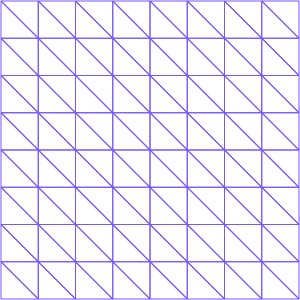

In [4]:
# Scikit FEM Custom Mesh Object
#mesh = fem.Mesh.load("charge_background.msh") # Can load in .msh file
mesh = fem.MeshTri().refined(3)
mesh

In [ ]:
Vh = fem.Basis(mesh,fem.ElementTriP1()) # I believe changing this to P2 means quadratic basis functions
Vh

<skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 128
  Number of DOFs: 81
  Size: 27648 B

In [ ]:
# Create the boundary matrices
A = a.assemble(Vh)
b = l.assemble(Vh)
print(type(A)) # Scipy sparse matrix??
print(A.shape,b.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(81, 81) (81,)


In [ ]:
# Get boundary degrees of freedom to set to zero. An empty call to Vh.get_dofs() does this (Vh is the basis functions)
D = Vh.get_dofs()
D

<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 28 ['u']

In [ ]:
x = fem.solve(*fem.condense(A,b,D=D)) #fem.condense eleminates all degrees of freedom D. 
# fem.solve is just a wrapper for scipy sparse solver. 
x.shape # Value of every degree of freedom u_i

(81,)

<Axes: >

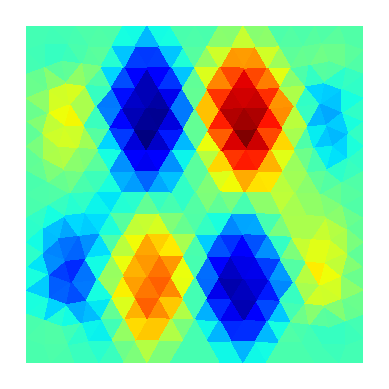

In [ ]:
plot(Vh, x)

# Minimizing a Functional: Poisson Equation Test

In [11]:
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
element = fem.ElementTriP1()
intorder = 4 # High order to capture everything accurately
basis = fem.CellBasis(mesh, element, intorder=intorder)


# Given a basis, return weights and interpolated values for u and grad u, all at the quadrature points

# First element returned: weights (elements,quadratures per element)
# Second element returned: phi_val (elements,quadratures,dof per element) - the eth entry is the interpolation matrix for eth element
# Third element returned: phi_grad (elements,dimenions,quadratures,dof) - the e,d matrix element is another matrix, that is the interpolation matrix for grad u in direction d in element e
def preprocess(basis):
    weights = jnp.array(basis.dx) # Only for quadrature points, not necessarily the nodes
    boundary_dofs = basis.get_dofs().flatten()
    elements,quad_per_element = weights.shape[0],weights.shape[1]

    X_ref = basis.quadrature[0]

    n_local_dofs = element.refdom.nnodes # 3 for Triangle
    val_list = []
    grad_list = []

    # Loop over local nodes to get basis functions
    for i in range(n_local_dofs):
        dfield = element.gbasis(basis.mapping, X_ref, i)[0]
        val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
        grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element

    phi_val = jnp.array(np.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
    phi_grad = jnp.array(np.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 

    dof_map = basis.element_dofs.T

    return weights,phi_val,phi_grad,dof_map,boundary_dofs

weights,phi_val,phi_grad,dof_map,boundary_dofs = preprocess(basis)
all_dofs = np.arange(basis.N)
interior_dofs = np.setdiff1d(all_dofs, boundary_dofs)
node_coords_global = jnp.array(mesh.doflocs.T)
boundary_condition = 0

In [12]:

# For u_global values of u, at each node/degree of freedom, return the interpolated values of u and gradient of u at the quadratures
# First element returned: u_quad, a (element,quadratures) matrix, each row is an element, each column is a quadrature point in the element, values are the interpolated value at the quadrature point, in that element
# Second element returned: u_grad, a (element,dimension,quadratures) matrix, each row is an element, then next axis is the dimension by which you take the derivate wrt to, then last axis is the quadrature point in that element, the gradient evaluated along that axis. 
def interpolate_values(u_global,dof_map,phi_val):
    u_local_arr = u_global[dof_map] # for every element, get the actual dof value at the nodes in the element
    u_quad = jnp.einsum('eqd,ed... -> eq...',phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
    return u_quad

def interpolate_grad(u_global,dof_map,phi_grad):
    u_local_arr = u_global[dof_map] # for every element, get the actual dof value at the nodes in the element
    grad_quad = jnp.einsum('exqd,ed -> xeq',phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
    return grad_quad

# u_quad,grad_quad = interpolate_values(x,dof_map,phi_val),interpolate_grad(x,dof_map,phi_grad)

In [15]:
# def functional(u_global):
#     u_quad,grad_quad = interpolate(u_global,dof_map,phi_val,phi_grad)

#     # Compute grad square norm
#     grad_sq = jnp.sum(grad_quad**2,axis=0) # sum along dimensions axis

#     f = 10.0

#     integrand = 0.5*grad_sq - f*u_quad  # Now an (elements,quadratures) matrix, only thing left to do is dot with weights
#     integral = jnp.sum(integrand * weights)
#     return integral


def laplacian(u,grad_u,x_vec):
    return jnp.sum(grad_u**2, axis=0) 

def v(x,y):
    return (100* jnp.sin(2*jnp.pi * x) * jnp.sin(jnp.pi * y))
    return (10 *(x)**2 +  10000*(y)**2)

def lagrangian(u, grad_u, x_vec):
    """
    Define your physics here.
    u: Scalar value at quad point
    grad_u: Vector [du/dx, du/dy] at quad point
    x_vec: Vector [x, y] at quad point
    """
    # Example: Poisson with Sinusoidal Source
    # L = 0.5 * |grad u|^2 - f(x)*u
    
    # 1. Kinetic / Stiffness Term
    # Sum of squares of gradient components
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    # 2. Source Term f(x)
    x, y = x_vec[0], x_vec[1]
    f = v(x,y) #-1 #jnp.sin(jnp.pi * x) * jnp.sin(2 * jnp.pi * y)
    
    potential = f * (u**2)
    
    return kinetic + potential

def integrate(lagrangian,u_global):
    u_quad = interpolate_values(u_global,dof_map,phi_val)
    grad_quad = interpolate_grad(u_global,dof_map,phi_grad)
    x_quad = interpolate_values(node_coords_global,dof_map,phi_val) # coordinates of quadrature points

    coords_q_T = x_quad.transpose(2, 0, 1)
    L_density = lagrangian(u_quad, grad_quad, coords_q_T)
    integral_result = jnp.sum(L_density * weights)
    return integral_result

def objective_with_bc(u_interior):
    u_full = jnp.ones(basis.N) * boundary_condition
    u_full = u_full.at[interior_dofs].set(u_interior)
    u_norm = integrate(lambda u,a,b: u**2,u_full)
    u_full /= jnp.sqrt(u_norm)

    return integrate(lagrangian,u_full)

x_quad = interpolate_values(node_coords_global,dof_map,phi_val) # coordinates of quadrature points

# u_values = cosMesh(None,None,basis.doflocs)
# u_laplace = laplacian(u_values,,None)
# ax = plot(basis,u_values,shading='gouraud')


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 8.660876726016696 Objective Value:66.17244875196988  Stepsize:0.48780217941505116  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 5.5957363090077825 Objective Value:50.518082482707946  Stepsize:0.7317032691225768  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 4.944646987868894 Objective Value:33.12400139948494  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 8.70332926496029 Objective Value:27.85783302452178  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 4.312490382724416 Objective Value:20.456367971303873  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 3.5103948973170334 Objective Value:13.80373905945325  Stepsize

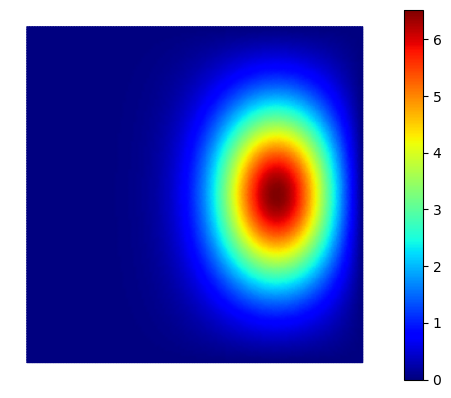

In [16]:
# Optimization Loop:
# Initial Guess (Random)
# key = jax.random.PRNGKey(0)

# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(interior_dofs))

print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective_with_bc,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points
# result = minimize(objective_with_bc, u_init_interior, method='L-BFGS-B',tol=1e-14)

#print(f"Optimization Success: {result.success}")
#print(f"Final Energy: {result.fun}")
u_final = np.ones(len(node_coords_global))*boundary_condition
u_final[interior_dofs] = result

# print(len(result),len(interior_dofs),len(boundary_dofs),len(node_coords_global))

# --- 6. VISUALIZATION ---
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot

print(f"Range: {np.min(u_final):.4e} to {np.max(u_final):.4e}")

ax = plot(basis, u_final, shading='gouraud')

plt.colorbar(ax.collections[0])
plt.show()

In [75]:
print(f"Solution Max: {np.max(u_final)}")
print(f"Solution Min: {np.min(u_final)}")

Solution Max: 1.2694364365646742
Solution Min: -0.011746072321466012


In [ ]:

# # Total number of quadrature points
# elements,quad_per_element = weights.shape[0] , weights.shape[1]
# total_quad_points = elements * quad_per_element # number of elements, times number of quadrature points per element
# rows = np.repeat(np.arange(total_quad_points), 3) # 3 DOFs per triangle
# # print(rows)
# dofs_per_elem = basis.element_dofs.T #Nodes per element
# cols = np.repeat(dofs_per_elem, quad_per_element, axis=0).flatten()

# X_ref,W_ref = fem.quadrature.get_quadrature(element,intorder) # Quadrature Points and Weights
# phi_local = element.tabulate(X_ref)[0]
# print(phi_local)

# Get the quadrature, in the Reference Coordinate System
# X_ref,W_ref = fem.quadrature.get_quadrature(element,intorder) # Quadrature Points and Weights

# Get the mapping


In [178]:
# 1. Get Weights (We know this is 128, 3)
weights = basis.dx 

# 2. Get Coordinates
# X_ref is shape (2, 3)
# mapping.F broadcasts this over 128 elements
coords = basis.mapping.F(X_ref) 

print(f"Weights shape: {weights.shape}") # (128, 3)
print(f"Coords shape:  {coords.shape}")  

# --- CRITICAL ALIGNMENT STEP ---
# Standard scikit-fem usually outputs Coords as (2, 3, 128) or (2, 128, 3).
# You need to make sure the last two dimensions match 'weights'.

if coords.shape == (2, 3, 128):
    # If coords are (Dim, Points, Elems) but weights are (Elems, Points)
    # We need to transpose weights to match coords
    weights = weights.T # Becomes (3, 128)
    print("Transposed weights to match coordinates.")

# Now flatten both
flat_weights = weights.flatten()
flat_coords = coords.reshape(2, -1)

print("READY FOR JAX:")
print(f"Flat Weights: {flat_weights.shape}")
print(f"Flat Coords:  {flat_coords.shape}")

Weights shape: (512, 6)
Coords shape:  (2, 512, 6)
READY FOR JAX:
Flat Weights: (3072,)
Flat Coords:  (2, 3072)


# Testing - Visualizing function and gradient

In [3]:
def plot_at_quad(vals,element):
    X_ref,W_ref = fem.quadrature.get_quadrature(element,intorder)
    coords = basis.mapping.F(X_ref) 
    flat_coords = coords.reshape(2, -1)

    plt.figure(figsize=(8, 8))
    sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

    # 3. Add colorbar and formatting
    plt.colorbar(sc)
    plt.title("Visualization at Quadrature Points")
    plt.axis('equal')
    plt.show()

# For u_global values of u, at each node/degree of freedom, return the interpolated values of u and gradient of u at the quadratures
# First element returned: u_quad, a (element,quadratures) matrix, each row is an element, each column is a quadrature point in the element, values are the interpolated value at the quadrature point, in that element
# Second element returned: u_grad, a (element,dimension,quadratures) matrix, each row is an element, then next axis is the dimension by which you take the derivate wrt to, then last axis is the quadrature point in that element, the gradient evaluated along that axis. 
def interpolate_values(u_global,dof_map,phi_val):
    u_local_arr = u_global[dof_map] # for every element, get the actual dof value at the nodes in the element
    u_quad = jnp.einsum('eqd,ed... -> eq...',phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
    return u_quad

def interpolate_grad(u_global,dof_map,phi_grad):
    u_local_arr = u_global[dof_map] # for every element, get the actual dof value at the nodes in the element
    grad_quad = jnp.einsum('exqd,ed -> xeq',phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
    return grad_quad


def preprocess(basis):
    weights = jnp.array(basis.dx) # Only for quadrature points, not necessarily the nodes
    boundary_dofs = basis.get_dofs().flatten()
    elements,quad_per_element = weights.shape[0],weights.shape[1]

    X_ref = basis.quadrature[0]

    n_local_dofs = element.refdom.nnodes # 3 for Triangle
    val_list = []
    grad_list = []

    # Loop over local nodes to get basis functions
    for i in range(n_local_dofs):
        dfield = element.gbasis(basis.mapping, X_ref, i)[0]
        val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
        grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element

    phi_val = jnp.array(np.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
    phi_grad = jnp.array(np.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 

    dof_map = basis.element_dofs.T

    return weights,phi_val,phi_grad,dof_map,boundary_dofs

In [4]:
# Define Basis
# mesh = fem.MeshTri.init_sqsymmetric().refined(5)
# mesh = fem.Mesh.load("charge_background.msh") # Can load in .msh file
# Create non-uniform spacing (e.g., finer near x=0 and y=0)
x = np.geomspace(0.1, 1.0, 10)  # Logarithmic spacing
y = np.linspace(0, 1, 10)**2    # Quadratic spacing

# Initialize the mesh using the tensor product of these vectors
mesh = fem.MeshTri.init_sqsymmetric().refined(5)

element = fem.ElementTriP1()
intorder = 4 # High order to capture everything accurately
basis = fem.CellBasis(mesh, element, intorder=intorder)

all_dofs = np.arange(basis.N)
boundary_dofs = basis.get_dofs().flatten()
interior_dofs = np.setdiff1d(all_dofs, boundary_dofs)
node_coords_global = jnp.array(mesh.doflocs.T)


def complete_arr(interior_vals,interior_dofs):
    u_full = jnp.zeros(basis.N)
    u_full = u_full.at[interior_dofs].set(interior_vals)
    return u_full

def cosMesh(u,grad_u,x_vec):
    x,y = x_vec[0],x_vec[1]
    return  jnp.cos(jnp.pi * x) * jnp.cos(jnp.pi * y)

def cosMeshInterior(u,grad_u,x_vec,interior_dofs):
    x,y = x_vec[0],x_vec[1]
    x,y = x[interior_dofs], y[interior_dofs] # truncate array at these indices
    # print(x,y)
    # print(x.shape,y.shape)

    interior_vals = jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

    #print(interior_vals)
    return complete_arr(interior_vals,interior_dofs)

# Interpolation matrices
weights,phi_val,phi_grad,dof_map,boundary_dofs = preprocess(basis)

# Get us the gradient, at the quadrature points
def interpolate_grad(u_global,dof_map,phi_grad):
    u_local_arr = u_global[dof_map] # for every element, get the actual dof value at the nodes in the element
    grad_quad = jnp.einsum('exqd,ed -> xeq',phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
    return grad_quad

# At the nodes
# u_values = cosMesh(None,None,basis.doflocs)
u_values = cosMeshInterior(None,None,basis.doflocs,interior_dofs)

# def get_grad_squared(u_values):
gradX,gradY = interpolate_grad(u_values,dof_map,phi_grad)
lap = gradX**2 + gradY**2

# Integral
weights = basis.dx
integral_eval = jnp.sum(lap*weights) #All at quadratrue points

u = interpolate_values(u_values,dof_map,phi_val)
u_sq = u**2
lap = gradX**2 + gradY**2

# 2. Create a scatter plot
X_ref,W_ref = fem.quadrature.get_quadrature(element,intorder)
coords = basis.mapping.F(X_ref) 
flat_coords = coords.reshape(2, -1)

# plot_at_quad(u_sq,element)
# mesh

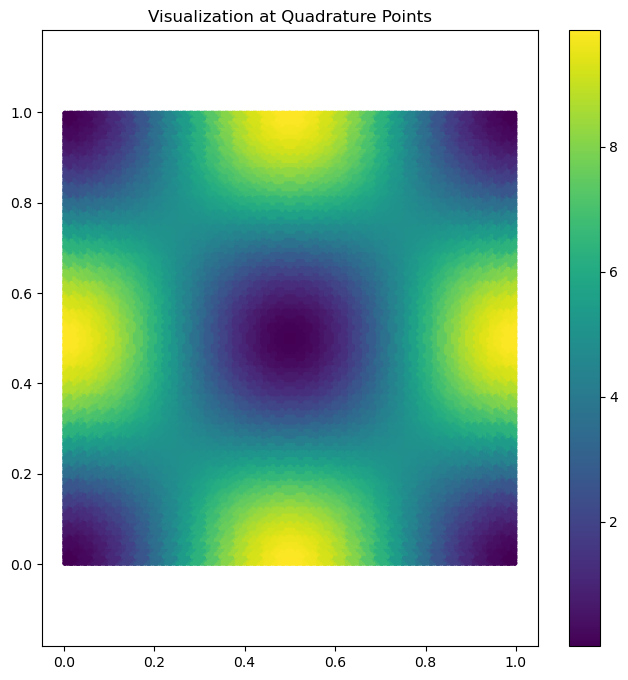

In [5]:
plot_at_quad(lap,element)

In [6]:
def get_integral(vals_at_quads,basis):
    weights = basis.dx
    return jnp.sum(weights*vals_at_quads)

print(f"Integral for U^2: {get_integral(u_sq,basis)}")
print(f"Integral for laplacian U: {get_integral(lap,basis)}")

Integral for U^2: 0.24983999326026898
Integral for laplacian U: 4.9338113836138895


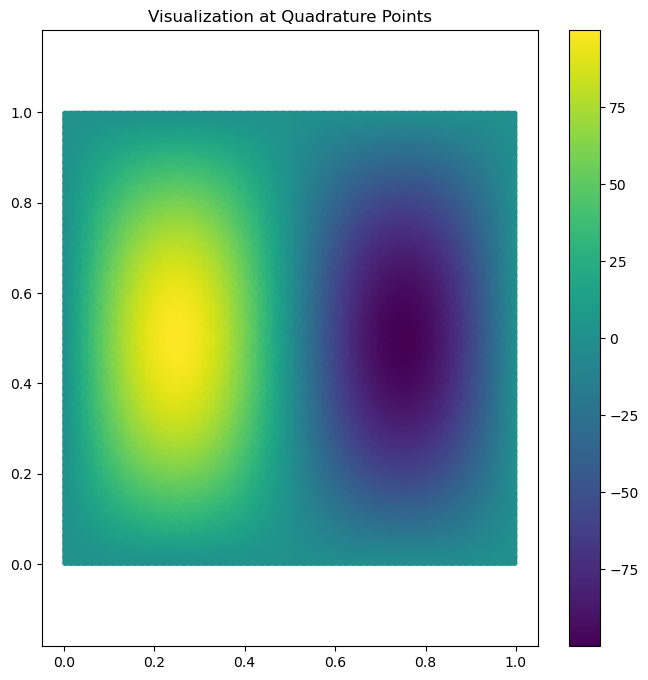

In [7]:
def plot_at_quad(vals,element):
    X_ref,W_ref = fem.quadrature.get_quadrature(element,intorder)
    coords = basis.mapping.F(X_ref) 
    flat_coords = coords.reshape(2, -1)

    plt.figure(figsize=(8, 8))
    sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

    # 3. Add colorbar and formatting
    plt.colorbar(sc)
    plt.title("Visualization at Quadrature Points")
    plt.axis('equal')
    plt.show()

def v(x,y):
    return (100* jnp.sin(2*jnp.pi * x) * jnp.sin(jnp.pi * y))
    return (10 *(x)**2 +  10000*(y)**2)
    return (100 * jnp.cos(4*jnp.pi*x) +  10000*(y-0.5)**2)

def get_pot_quad(node_coords_global,dof_map,phi_val):
    x_quad = interpolate_values(node_coords_global,dof_map,phi_val) 
    x,y = x_quad.transpose(2, 0, 1) 
    f = v(x,y) #evaluted at quadratures 
    return f

# x_quad = interpolate_values(node_coords_global,dof_map,phi_val) 
# x,y = x_quad.transpose(2, 0, 1) 
# vals = v(x,y)

vals = get_pot_quad(node_coords_global,dof_map,phi_val)
plot_at_quad(vals,element)

In [8]:
def normalize(u_vals,dof_map,phi_val):
    u_quad = interpolate_values(u_vals,dof_map,phi_val)
    u_norm_sq = get_integral(u_quad**2,basis)
    u_norm  = jnp.sqrt(u_norm_sq)
    return u_vals/u_norm

def ke(u_vals,dof_map,phi_val,phi_grad,basis):
    u_vals = normalize(u_vals,dof_map,phi_val)
    u_grad_intX,u_grad_intY = interpolate_grad(u_vals,dof_map,phi_grad) 

    integral_eval = get_integral(u_grad_intX**2 + u_grad_intY**2,basis) / 2

    return integral_eval


def pe(u_vals,dof_map,phi_val,phi_grad,basis):
    u_vals = normalize(u_vals,dof_map,phi_val)
    u_quad = interpolate_values(u_vals,dof_map,phi_val) 
 

    f = get_pot_quad(node_coords_global,dof_map,phi_val) 
    density = u_quad**2 * f
    integral_eval = get_integral(density,basis)
    return integral_eval

def cost_func(interior_vals,dof_map,phi_val,phi_grad,interior_dofs,basis):
    u_vals = complete_arr(interior_vals,interior_dofs)
    return ke(u_vals,dof_map,phi_val,phi_grad,basis) + pe(u_vals,dof_map,phi_val,phi_grad,basis)

In [9]:
# Get interior values
def getInteriorValsTest(u,grad_u,x_vec,interior_dofs):
    x,y = x_vec[0],x_vec[1]
    x,y = x[interior_dofs], y[interior_dofs] # truncate array at these indices
    interior_vals = jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)
    return interior_vals

interior_vals = getInteriorValsTest(None,None,basis.doflocs,interior_dofs)
cost = cost_func(interior_vals,dof_map,phi_val,phi_grad,interior_dofs,basis)
print(cost)

9.873942356526817



Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 8.660876726016696 Objective Value:66.17244875196991  Stepsize:0.4878021794150511  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 5.595736309007781 Objective Value:50.51808248270794  Stepsize:0.7317032691225767  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 4.944646987868896 Objective Value:33.12400139948493  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 8.703329264960285 Objective Value:27.85783302452179  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 4.312490382724413 Objective Value:20.45636797130387  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 3.510394897317022 Objective Value:13.803739059453253  Stepsize:1.

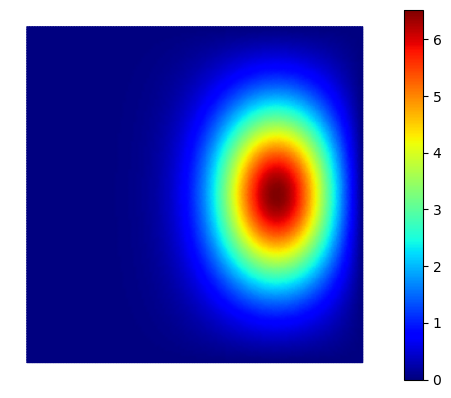

In [10]:
u_init_interior = jnp.ones(len(interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=lambda a: cost_func(a,dof_map,phi_val,phi_grad,interior_dofs,basis),tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params


# --- 6. VISUALIZATION ---
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot

# 4. Reconstruct Result for Plotting
u_final = np.zeros(basis.N)
u_final[interior_dofs] = result
u_final[boundary_dofs] = 0.0 # Enforce strict zero at boundary

print(f"Range: {np.min(u_final):.4e} to {np.max(u_final):.4e}")

ax = plot(basis, u_final, shading='gouraud')

plt.colorbar(ax.collections[0])
plt.show()